# Portfolio optimization 

### Portfolio allocation vector

In this example we show how to do portfolio optimization using CVXPY.
We begin with the basic definitions.
In portfolio optimization we have some amount of money to invest in any of $n$ different assets. 
We choose what fraction $w_i$ of our money to invest in each asset $i$, $i=1, \ldots, n$.

We call $w\in {\bf R}^n$ the *portfolio allocation vector*.
We of course have the constraint that ${\mathbf 1}^T w =1$.
The allocation $w_i<0$ means a *short position* in asset $i$, or that we borrow shares to sell now that we must replace later.
The allocation $w \geq 0$ is a *long only* portfolio.
The quantity
$$ \|w \|_1 = {\mathbf 1}^T w_+ + {\mathbf 1}^T w_- $$
is known as *leverage* (or *gross market value*).

### Asset returns

We will only model investments held for one period. The initial prices are $p_i > 0$. The end of period prices are $p_i^+ >0$. The asset (fractional) returns are $r_i = (p_i^+-p_i)/p_i$. The porfolio (fractional) return is $R = r^Tw$.

A common model is that $r$ is a random variable with mean ${\bf E}r = \mu$ and covariance ${\bf E{(r-\mu)(r-\mu)^T}} = \Sigma$.
It follows that $R$ is a random variable with ${\bf E}R = \mu^T w$ and ${\bf var}(R) = w^T\Sigma w$.
${\bf E}R$ is the (mean) *expected return* of the portfolio. ${\bf var}(R)$ is the *risk* of the portfolio.
(Risk is also sometimes given as ${\bf std}(R) = \sqrt{{\bf var}(R)}$.)

Portfolio optimization has two competing objectives: high return and low risk.

### Classical (Markowitz) portfolio optimization

Classical (Markowitz) portfolio optimization solves the optimization problem

\begin{array}{ll} \mbox{maximize} & \mu^T w - \gamma w^T\Sigma w\\
\mbox{subject to} & {\bf 1}^T w = 1, \quad w \in {\cal W},
\end{array}

where $w \in {\bf R}^n$ is the optimization variable, $\cal W$ is a set of allowed portfolios (e.g., ${\cal W} = {\bf R}_+^n$ for a long only portfolio), and $\gamma >0$ is the *risk aversion parameter*.

The objective $\mu^Tw - \gamma w^T\Sigma w$ is the *risk-adjusted return*. Varying $\gamma$ gives the optimal *risk-return trade-off*. 
We can get the same risk-return trade-off by fixing return and minimizing risk.

### Example

In the following code we compute and plot the optimal risk-return trade-off for $10$ assets, restricting ourselves to a long only portfolio.

In [1]:
import cvxpy as cvx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# Generate data for long only portfolio optimization.
np.random.seed(1)
n = 10
mu = np.abs(np.random.randn(n, 1))
Sigma = np.random.randn(n, n)
Sigma = Sigma.T.dot(Sigma)

In [3]:
# Long only portfolio optimization.
w = cvx.Variable(n)
gamma = cvx.Parameter(nonneg=True)
ret = mu.T*w 
risk = cvx.quad_form(w, Sigma)
prob = cvx.Problem(cvx.Maximize(ret - gamma*risk), 
                   [cvx.sum(w) == 1, 
                    w >= 0])

In [4]:
# Compute trade-off curve.
SAMPLES = 100
risk_data = np.zeros(SAMPLES)
ret_data = np.zeros(SAMPLES)
gamma_vals = np.logspace(-2, 3, num=SAMPLES)

for i in range(SAMPLES):
    gamma.value = gamma_vals[i]
    prob.solve()
    risk_data[i] = np.sqrt(risk.value)
    ret_data[i] = ret.value

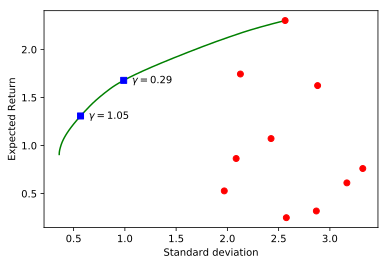

In [5]:
# Plot long only trade-off curve.
markers_on = [29, 40]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(risk_data, ret_data, 'g-')

for marker in markers_on:
    plt.plot(risk_data[marker], ret_data[marker], 'bs')
    ax.annotate(r"$\gamma = {:.2f}$".format(gamma_vals[marker]), 
                xy=(risk_data[marker]+.08, ret_data[marker]-.03))

for i in range(n):
    plt.plot(np.sqrt(Sigma[i,i]), mu[i], 'ro')
plt.xlabel('Standard deviation')
plt.ylabel('Expected Return')
plt.show()

We plot below the expected return distributions for the two risk aversion values marked on the trade-off curve.
Notice that the probability of a loss (the area under the curve to the left of the red dotted line) is near 0 for the high risk aversion value and far above 0 for the low risk aversion value.

/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  import sys


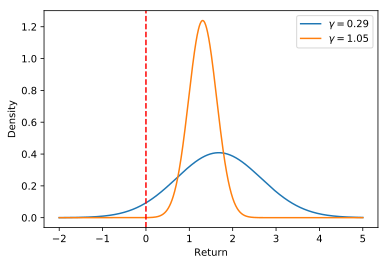

In [6]:
# Plot return distributions for two points on the trade-off curve.
plt.figure()
for marker in markers_on:
    gamma.value = gamma_vals[marker]
    prob.solve()
    x = np.linspace(-2, 5, 1000)
    plt.plot(x, mlab.normpdf(x, ret.value, risk.value), 
             label=r"$\gamma = {:.2f}$".format(gamma.value))

plt.axvline(x=0, linestyle='--', color='r')
plt.xlabel('Return')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.show()

### Portfolio constraints

There are many other possible portfolio constraints besides the long only constraint. With no constraints (${\cal W} = {\bf R}^n$), the optimization problem has a simple analytical solution. We will look in detail at a *leverage limit*, or the constraint that $\|w \|_1 \leq L^\mathrm{max}$.


Another interesting constraint is the *market neutral* (or *beta neutral*) constraint $m^T \Sigma w =0$, where $m_i$ is the capitalization of asset $i$.
$M = m^Tr$ is the *market return*, and $m^T \Sigma w = {\bf cov}(M,R)$.
The market neutral constraint ensures that the portfolio's expted return is uncorrelated with the market return.

### Example

In the following code we compute and plot optimal risk-return trade-off curves for leverage limits of 1, 2, and 4.
Notice that more leverage increases returns and allows greater risk.

In [7]:
# Portfolio optimization with leverage limit.
Lmax = cvx.Parameter()
prob = cvx.Problem(cvx.Maximize(ret - gamma*risk), 
                   [cvx.sum(w) == 1, 
                    cvx.norm(w, 1) <= Lmax])

In [8]:
# Compute trade-off curve for each leverage limit.
L_vals = [1, 2, 4]
SAMPLES = 100
risk_data = np.zeros((len(L_vals), SAMPLES))
ret_data = np.zeros((len(L_vals), SAMPLES))
gamma_vals = np.logspace(-2, 3, num=SAMPLES)

for k, L_val in enumerate(L_vals):
    for i in range(SAMPLES):
        Lmax.value = L_val
        gamma.value = gamma_vals[i]
        prob.solve()
        risk_data[k, i] = np.sqrt(risk.value)
        ret_data[k, i] = ret.value

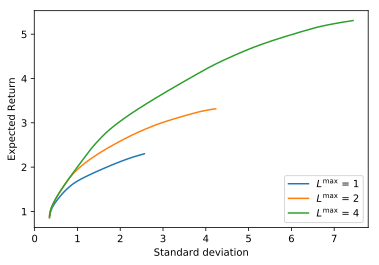

In [12]:
# Plot trade-off curves for each leverage limit.
for idx, L_val in enumerate(L_vals):
    plt.plot(risk_data[idx,:], ret_data[idx,:], 
             label=r"$L^{{\max}}$ = {}".format(L_val))

plt.xlabel('Standard deviation')
plt.ylabel('Expected Return')
plt.legend(loc='lower right')
plt.show()

We next examine the points on each trade-off curve where $w^T\Sigma w = 2$.
We plot the amount of each asset held in each portfolio as bar graphs. (Negative holdings indicate a short position.)
Notice that some assets are held in a long position for the low leverage portfolio but in a short position in the higher leverage portfolios. 

In [13]:
# Portfolio optimization with a leverage limit and a bound on risk.
prob = cvx.Problem(cvx.Maximize(ret), 
                  [cvx.sum(w) == 1, 
                   cvx.norm(w, 1) <= Lmax,
                   risk <= 2])

In [14]:
# Compute solution for different leverage limits.
w_vals = []
for k, L_val in enumerate(L_vals):
    Lmax.value = L_val
    prob.solve()
    w_vals.append( w.value )

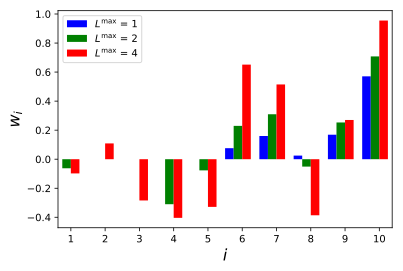

In [33]:
# Plot bar graph of holdings for different leverage limits.
colors = ['b', 'g', 'r']
indices = np.argsort(mu.flatten())
for idx, L_val in enumerate(L_vals):
     plt.bar(np.arange(1,n+1) + 0.25*idx - 0.375, 
             w_vals[idx][indices], color=colors[idx], 
             label=r"$L^{{\max}}$ = {}".format(L_val), width = 0.25)
plt.ylabel(r"$w_i$", fontsize=16)
plt.xlabel(r"$i$", fontsize=16)
plt.xlim([1-0.375, 10+.375])
plt.xticks(np.arange(1,n+1))
plt.legend()
plt.show()

### Variations

There are many more variations of classical portfolio optimization. We might require that $\mu^T w \geq R^\mathrm{min}$ and minimize $w^T \Sigma w$ or $\|\Sigma ^{1/2} w\|_2$.
We could include the (broker) cost of short positions as the penalty $s^T (w)_-$ for some $s \geq 0$.
We could include transaction costs (from a previous portfolio $w^\mathrm{prev}$) as the penalty

$$
\kappa ^T |w-w^\mathrm{prev}|^\eta, \quad
\kappa \geq 0.
$$


Common values of $\eta$ are $\eta =1, ~ 3/2, ~2$.


### Factor covariance model

A particularly common and useful variation is to model the covariance matrix $\Sigma$ as a factor model

$$
\Sigma  =  F \tilde \Sigma F^T + D,
$$

where  $F \in {\bf R}^{n \times k}$, $k \ll n$ is the *factor loading matrix*. $k$ is the number of factors (or sectors) (typically 10s). $F_{ij}$ is the loading of asset $i$ to factor $j$.
$D$ is a diagonal matrix; $D_{ii}>0$ is the *idiosyncratic risk*. $\tilde \Sigma > 0$ is the *factor covariance matrix*.

$F^Tw \in {\bf R}^k$ gives the portfolio *factor exposures*. A portfolio is *factor $j$ neutral* if $(F^Tw)_j=0$.


### Portfolio optimization with factor covariance model

Using the factor covariance model, we frame the portfolio optimization problem as 

\begin{array}{ll} \mbox{maximize} & \mu^T w - \gamma \left(f^T \tilde \Sigma f  + w^TDw \right) \\
\mbox{subject to} & {\bf 1}^T w = 1, \quad f=F^Tw\\
& w \in {\cal W}, \quad f \in {\cal F},
\end{array}

where the variables are the allocations $w \in {\bf R}^n$ and factor exposures $f\in {\bf R}^k$ and $\cal F$ gives the factor exposure constraints.

Using the factor covariance model in the optimization problem has a computational advantage. The solve time is $O(nk^2)$ versus $O(n^3)$ for the standard problem.

### Example

In the following code we generate and solve a portfolio optimization problem with 50 factors and 3000 assets.
We set the leverage limit $=2$ and $\gamma=0.1$.

We solve the problem both with the covariance given as a single matrix and as a factor model.
Using CVXPY with the ECOS solver running in a single thread, the solve time was 687.26 seconds for the single matrix formulation and 0.58 seconds for the factor model formulation.
We collected the timings on a MacBook Pro with an Intel Core i7 processor.

In [34]:
# Generate data for factor model.
n = 3000
m = 50
np.random.seed(1)
mu = np.abs(np.random.randn(n, 1))
Sigma_tilde = np.random.randn(m, m)
Sigma_tilde = Sigma_tilde.T.dot(Sigma_tilde)
D = np.diag(np.random.uniform(0, 0.9, size=n))
F = np.random.randn(n, m)

In [19]:
# Factor model portfolio optimization.
w = cvx.Variable(n)
f = F.T*w
gamma = cvx.Parameter(nonneg=True)
Lmax = cvx.Parameter()
ret = mu.T*w 
risk = cvx.quad_form(f, Sigma_tilde) + cvx.quad_form(w, D)
prob_factor = cvx.Problem(cvx.Maximize(ret - gamma*risk), 
                         [cvx.sum(w) == 1, 
                          cvx.norm(w, 1) <= Lmax])

# Solve the factor model problem.
Lmax.value = 2
gamma.value = 0.1
prob_factor.solve(verbose=True)


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -7.950e-01  -1.112e+01  +2e+04  1e+00  1e-01  1e+00  3e+00    ---    ---    2  1  - |  -  - 
 1  -1.203e+01  -1.321e+01  +2e+03  9e-01  2e-02  5e-01  4e-01  0.9890  1e-01   1  1  1 |  0  0
 2  -1.018e+01  -1.031e+01  +2e+02  2e-01  2e-03  5e-03  3e-02  0.9051  8e-04   1  1  1 |  0  0
 3  -6.658e+00  -6.725e+00  +2e+02  1e-01  6e-04  7e-03  3e-02  0.2603  4e-01   1  2  2 |  0  0
 4  -6.352e+00  -6.398e+00  +1e+02  6e-02  4e-04  1e-02  2e-02  0.6483  7e-01   2  2  2 |  0  0
 5  -5.930e+00  -5.962e+00  +1e+02  4e-02  3e-04  8e-03  2e-02  0.3419  4e-01   2  2  2 |  0  0
 6  -6.371e+00  -6.404e+00  +1e+02  4e-02  3e-04  1e-02  2e-02  0.2067  9e-01   2  2  2 |  0  0
 7  -5.586e+00  -5.604e+00  +7e+01  2e-02  2e-04  7e-03  1e-02  0.7054  6e-01   2  2  2 |  0  0
 8  -5.647e+00  -5.665e+00  +7e+01  2e-02  2e-

4.601466742631647

In [20]:
# Standard portfolio optimization with data from factor model.
risk = cvx.quad_form(w, F.dot(Sigma_tilde).dot(F.T) + D)
prob = cvx.Problem(cvx.Maximize(ret - gamma*risk), 
                   [cvx.sum(w) == 1, 
                    cvx.norm(w, 1) <= Lmax])

# Uncomment to solve the problem.
# WARNING: this will take many minutes to run.
# prob.solve(verbose=True)